# ECSE 415 - Intro. To Computer Vision
## Tutorial: Clustering and Segmentation

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift

## K-Means Clustering

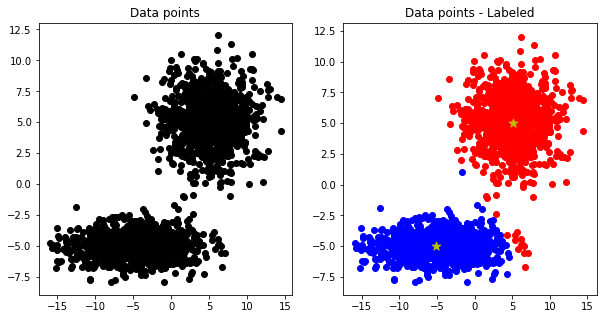

In [2]:
# generate data
data = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(1000,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([4,1]), size=(1000,2)))))

# before calling openCV's kmeans, we need to specify the stop criteria
# stop when either 100 iterations or an accuracy of 1 is reached
# define criteria = (type, max_iter=100, epsilon=1.0)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)


# set number of clusters
K = 2

# apply Kmeans
# cv2.kmeans(data, K, bestLabels, criteria, attempts, flags[, centers]) → retval, bestLabels, centers
# compactness: the sum of squared distance from each point to their corresponding centers
# labels: the label array (each element marked '0', '1', '2', etc.)
# centers: array of centers of clusters

compactness, labels, centers = cv2.kmeans(data, K, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

# can easily split the data into different clusters depending on their labels
A = data[labels.ravel()==0]
B = data[labels.ravel()==1]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data[:,0], data[:,1],"ko")
plt.title("Data points")
plt.subplot(122)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Data points - Labeled")
plt.show()

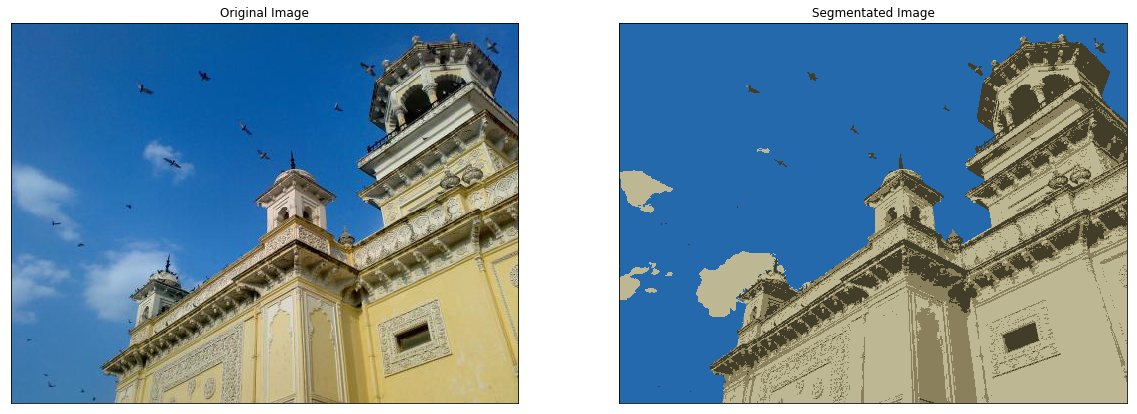

In [3]:
img = cv2.cvtColor(cv2.imread('home.jpg'), cv2.COLOR_BGR2RGB)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
out = center[label.flatten()]
out = out.reshape((img.shape))

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()

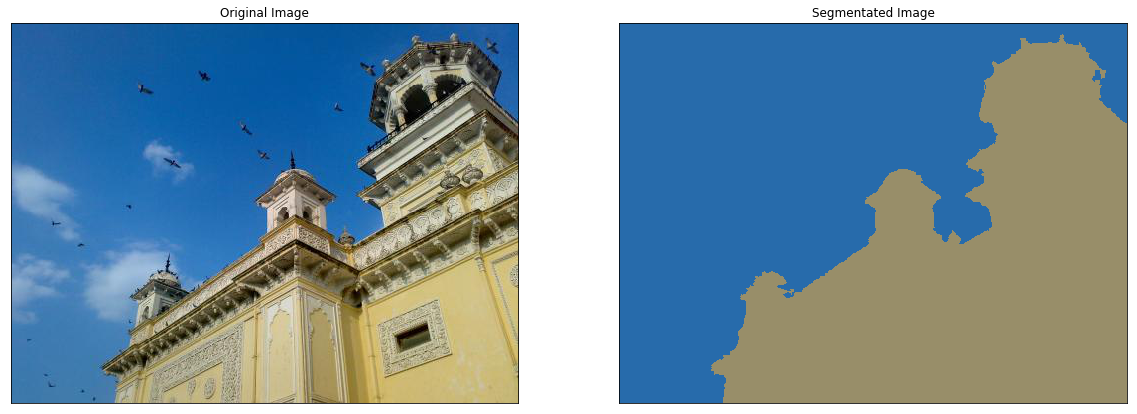

In [4]:
img = cv2.cvtColor(cv2.imread('home.jpg'), cv2.COLOR_BGR2RGB)

# slic(image, n_segments=100, compactness=10.0, max_iter=10,
#     sigma=0, spacing=None, multichannel=True, convert2lab=None,
#     enforce_connectivity=True, min_size_factor=0.5, max_size_factor=3, slic_zero=False)

# n_segments : The (approximate) number of labels in the segmented output image.
# compactness: Balances color proximity and space proximity. Higher values give more weight to space proximity.
# spacing: The voxel spacing along each image dimension. By default, slic assumes uniform spacing.
# multichannel: Whether the last axis of the image is to be interpreted as multiple channels or another spatial dimension.
# enforce_connectivity: Whether the generated segments are connected or not
# min_size_factor: Proportion of the minimum segment size to be removed
# max_size_factor: Proportion of the maximum connected segment size.
    
labels = segmentation.slic(img, compactness=0.1, n_segments=3)
out = color.label2rgb(labels, img, kind='avg')

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()

## MeanShift Segmentation

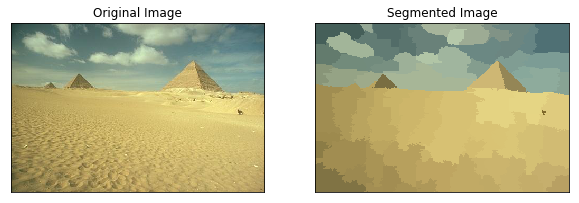

In [5]:

# Read image
img = cv2.cvtColor(cv2.imread('pyramids.jpg'), cv2.COLOR_BGR2RGB)

#skimage.segmentation.quickshift(image, ratio=1.0, kernel_size=5, max_dist=10,
#                                return_tree=False, sigma=0, convert2lab=True, random_seed=42)
# image(width, height, channels):Input image.
# ratio: ratio of color-space proximity and image-space proximity.
# kernel_size: Variance of Gaussian kernel used in smoothing the sample density.
# max_dist: Cut-off point for data distances.
# return_tree: Whether to return the full segmentation hierarchy tree and distances.
# sigma: Variance of Gaussian smoothing as preprocessing.
# convert2lab: Whether the input should be converted to Lab colorspace prior to segmentation.
# random_seed: Random seed used for breaking ties

# apply meanshift
label = quickshift(img, max_dist=20)
out = color.label2rgb(label, img, kind='avg')

# display
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(out)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
plt.show()

## Graph Cut Segmentation

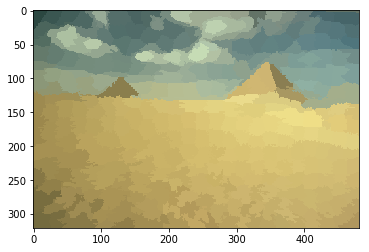

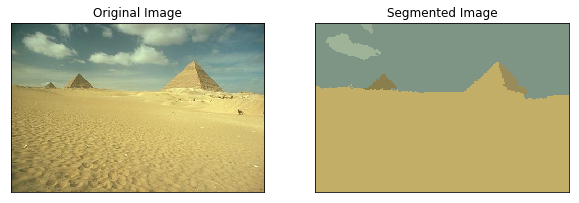

In [6]:

# Read image
img = cv2.cvtColor(cv2.imread('pyramids.jpg'), cv2.COLOR_BGR2RGB)

# apply k-means. This will generate super pixels
labels1 = segmentation.slic(img, compactness=5, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')
plt.imshow(out1); plt.show()

# build region adjacency graph
# rag_mean_color(image, labels, connectivity=2, mode='distance', sigma=255.0)
# connectivity: Pixels with a squared distance less than connectivity from each other are considered adjacent.
# mode: {‘distance’, ‘similarity’}
#         ‘distance’ : The weight between two adjacent regions is the |c1−c2|
#         ‘similarity’ : The weight between two adjacent is e−d2/sigma; where d=|c1−c2|
# sigma: Used for computation when mode is “similarity”.
    
g = graph.rag_mean_color(img, labels1, mode='similarity')

# Apply graph cut
# cut_normalized(labels, rag, thresh=0.001, num_cuts=10, in_place=True, max_edge=1.0)
# labels: The array of labels.
# rag: The region adjacency graph.
# thresh: The threshold. A subgraph won’t be further subdivided if the value of the N-cut exceeds thresh.
# num_cuts: The number or N-cuts to perform before determining the optimal one.
# in_place: If set, modifies rag in place.
# max_edge: The maximum possible value of an edge in the RAG.

labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

# display
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(out2)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
plt.show()